In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from IPython.display import FileLink

plt.ion()   # interactive mode

In [2]:
STORAGE_DIR = '/home/tyler/storage/dogbreed2/'
SAMPLE_SUBMISSION = STORAGE_DIR + 'sample_submission.csv'
RESULT_FILE = STORAGE_DIR + 'results/dogbreeds_results.csv'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(STORAGE_DIR, x),data_transforms[x])
        for x in ['train', 'valid', 'test']
}

dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,shuffle=x != 'test', num_workers=4)
        for x in ['train', 'valid', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

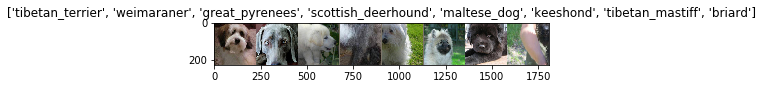

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 120)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.7237 Acc: 0.2085
valid Loss: 1.9032 Acc: 0.5570
Epoch 1/9
----------
train Loss: 2.4716 Acc: 0.4506
valid Loss: 1.2171 Acc: 0.7020
Epoch 2/9
----------
train Loss: 2.0498 Acc: 0.5128
valid Loss: 1.0060 Acc: 0.7260
Epoch 3/9
----------
train Loss: 1.8533 Acc: 0.5469
valid Loss: 0.8965 Acc: 0.7385
Epoch 4/9
----------
train Loss: 1.7400 Acc: 0.5690
valid Loss: 0.8419 Acc: 0.7580
Epoch 5/9
----------
train Loss: 1.6969 Acc: 0.5722
valid Loss: 0.8003 Acc: 0.7675
Epoch 6/9
----------
train Loss: 1.6123 Acc: 0.5832
valid Loss: 0.7773 Acc: 0.7725
Epoch 7/9
----------
train Loss: 1.5360 Acc: 0.6149
valid Loss: 0.7393 Acc: 0.7825
Epoch 8/9
----------
train Loss: 1.4960 Acc: 0.6282
valid Loss: 0.7409 Acc: 0.7815
Epoch 9/9
----------
train Loss: 1.5033 Acc: 0.6286
valid Loss: 0.7270 Acc: 0.7885
Training complete in 9m 39s
Best val Acc: 0.788500


In [ ]:
for param in model_conv.parameters():
    param.requires_grad = True

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [ ]:
visualize_model(model_conv)

In [9]:
path = STORAGE_DIR + 'results/'
torch.save(model_conv.state_dict(), path + 'weights.torch')

In [12]:
model_conv.load_state_dict(torch.load(path + 'weights.torch'))
model_conv.eval()
predictions = []

for index, test_value in enumerate(dataloders['test']):
    val = test_value[0].cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = model_conv(input)
    predictions.append(func.softmax(output, dim=1).cpu().data.numpy())
    print('\r ' + str(index), end='') 
    
predictions = np.concatenate(predictions)
    
predictions

 1294

array([[  2.60355455e-06,   2.03518243e-06,   2.85900553e-10, ...,
          7.31010852e-09,   3.35909220e-08,   1.08513564e-06],
       [  4.60129518e-10,   7.43373474e-10,   1.72242030e-11, ...,
          5.30684774e-10,   8.73405626e-10,   7.11824433e-10],
       [  2.01974668e-08,   3.43953980e-05,   1.34250698e-07, ...,
          4.58935375e-07,   1.00249974e-06,   6.37111199e-08],
       ..., 
       [  5.20917865e-06,   4.44565302e-07,   4.15414135e-04, ...,
          5.84052214e-06,   3.22712905e-04,   3.18032071e-05],
       [  9.93790105e-04,   2.56612075e-05,   6.75997626e-07, ...,
          2.00657610e-06,   8.96205820e-05,   1.46539686e-02],
       [  5.84452710e-06,   2.71463022e-03,   2.46111449e-04, ...,
          3.00248316e-03,   7.70999584e-04,   9.31445641e-07]], dtype=float32)

In [13]:
imgs = dataloders['test'].dataset.imgs
filenames = []
for file_loc in imgs:
    filenames.append(os.path.splitext(os.path.basename(file_loc[0]))[0])

In [14]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)
columns = sample_submission.columns.values
rows = []

for index, row in enumerate(predictions):
    row = row.tolist()
    row.insert(0, filenames[index])
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [15]:
df.to_csv(RESULT_FILE, sep=',', index=False)

In [16]:
%cd ~/notebooks/dogbreed
FileLink("dogbreeds_results.csv")

/home/tyler/notebooks/dogbreed


/home/tyler/notebooks/dogbreed/dogbreeds_results.csv